본 실험은 박장원님의 Open Source를 이용하였습니다.
 - https://monologg.kr/
 - https://github.com/monologg/KoELECTRA

**<H1>Electra Model<H1>**
*Pre-training Text Encoders as Discriminators Rather Than Generators*

논문 : https://openreview.net/pdf?id=r1xMH1BtvB


---


<p>Electra 모델은 기존 생성모델 대신 판별모델을 사용하여 사전 학습하는 모델이다.<p>

<p>BERT 모델과 RoBERTa,AlBERT,GOOGLE T5 등 사전학습 방법은 Masked Language Modeling 혹은 Corrupted Language Modeling을 주로 사용했다는 공통점이 있다.<p>

<p>이러한 사전학습 방법은 단어의 뜻 뿐만 아니라 문맥적인 의미를 포착하는 방법을 학습한다. 즉 다량의 학습 코퍼스가 존재해야하며, 대량의 계산을 통해 좋은 성능을 내왔다.<p>

<p>하지만 Electra모델은 Replaced Token Detection 방법을 제안하는데, MLM에서 일부 토큰을 [MASK]처리 하듯이, 몇몇 토큰을 골라 generator가 대안 토큰을 제시한다. 이후 메인 모델은 generator가 대체시킨 토큰인지 아닌지(real input token or fake input token)를 판별하는 dicriminator로써 학습한다. 즉, Electra model은 기존 GAN(Generative Adversarial Network)의 아이디어를 차용하여 만들어진 Model이다.<p>

<P>electra model은 적은 컴퓨팅으로 만들어진 모델이다. 학습량이 많아지(compute and Large data)면 오히려 타 pre-training model에 비해 정확도가 떨어지는 현상이 일어난다.<p>

# **koelectra model Train**

> Model : koElectra-model-small-v3


> Dataset : NSMC

---

본 Electra model은 pre-training되어있는 model로, 사용하기 전 pine-tuning을 거친다.
즉, 내가 어떻게 활용할까에 따라서 이미 학습 된 model을 pine-tuning하는 것 이다. 

본 실험(electra model을 이용한 감성분석 model 제작)에서 다른 Model을 사용하는 것이 아닌 electra model을 사용 한 이유가 여기서 나온다.
pre-training되어 있는 model을 가져와 pine-tuning하는 방식은, 직접 Model을 학습시키는 것 보다 간단하고 빠르기 때문이다.

또한, 내가 원하는대로 pine-tuning만 시켜주면 되는 Model이라 그 활용성이 매우 뛰어날 것 으로 보여 electra model을 사용하였다.

---

# NSMC
NSMC는 네이버 영화 리뷰 코퍼스다. 약 150,000개 Train Data와 약 50,000개의 Test Data로 구성되어 있다. 하지만 200,000개 데이터가 온전한 것은 아니다. 중간에 NaN인 경우와, 중복인 데이터가 존재한다. 따라서, NSMC를 사용하기 전 NaN과 중복 데이터를 삭제하여 사용해야한다.

각 데이터는 label이 되어 있으며, 0은 부정을, 1은 긍정을 나타낸다.

리뷰의 내용은 document를 확인하면 알 수 있다.

---

In [ ]:
# google drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# HuggingFace transformers 설치 및 NSMC 데이터셋 다운로드
!pip install transformers
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

     |████████████████████████████████| 3.5 MB 14.7 MB/s 
     |████████████████████████████████| 895 kB 68.0 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 6.8 MB 51.4 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
--2022-01-28 00:44:26--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.04s   

2022-01-28 00:44:28 (112 MB/s) - ‘ratings_test.txt’

In [ ]:
# 0 부정 | 1 긍정
# 생각보다 좀 별로인 데이터 세트...

!head ratings_train.txt
!head ratings_test.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1
id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 11.4 MB/s 
     |████████████████████████████████| 895 kB 63.9 MB/s 
     |████████████████████████████████| 3.3 MB 69.3 MB/s 
     |████████████████████████████████| 596 kB 65.4 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
# GPU 사용
# Multi GPU 생가면 DDP 진행 해 볼 것(예정)
device = torch.device("cuda")

In [ ]:
class NSMCDataset(Dataset):
  
  def __init__(self, csv_file):
    # 일부 값중에 NaN이 있음
    self.dataset = pd.read_csv(csv_file, sep='\t').dropna(axis=0) 
    # 중복제거
    self.dataset.drop_duplicates(subset=['document'], inplace=True)
    self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

    print(self.dataset.describe())
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 1:3].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y 

In [ ]:
# NSMC Datasets 사용하기

train_dataset = NSMCDataset("ratings_train.txt")
test_dataset = NSMCDataset("ratings_test.txt")

                 id          label
count  1.461820e+05  146182.000000
mean   6.779186e+06       0.498283
std    2.919223e+06       0.499999
min    3.300000e+01       0.000000
25%    4.814832e+06       0.000000
50%    7.581160e+06       0.000000
75%    9.274760e+06       1.000000
max    1.027815e+07       1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000


In [ ]:
#모델 불러오기, koElectra 모델 중 koElectra-small-v3를 사용
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator").to(device)

Downloading:   0%|          | 0.00/54.0M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/sentiment_analysis/model.pt"))
#colab에 model 저장.

<All keys matched successfully>

In [ ]:
# 모델 레이어 보기
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [ ]:
# train arguments 세팅
# Epochs / Batch size 수정

epochs = 5
batch_size = 32

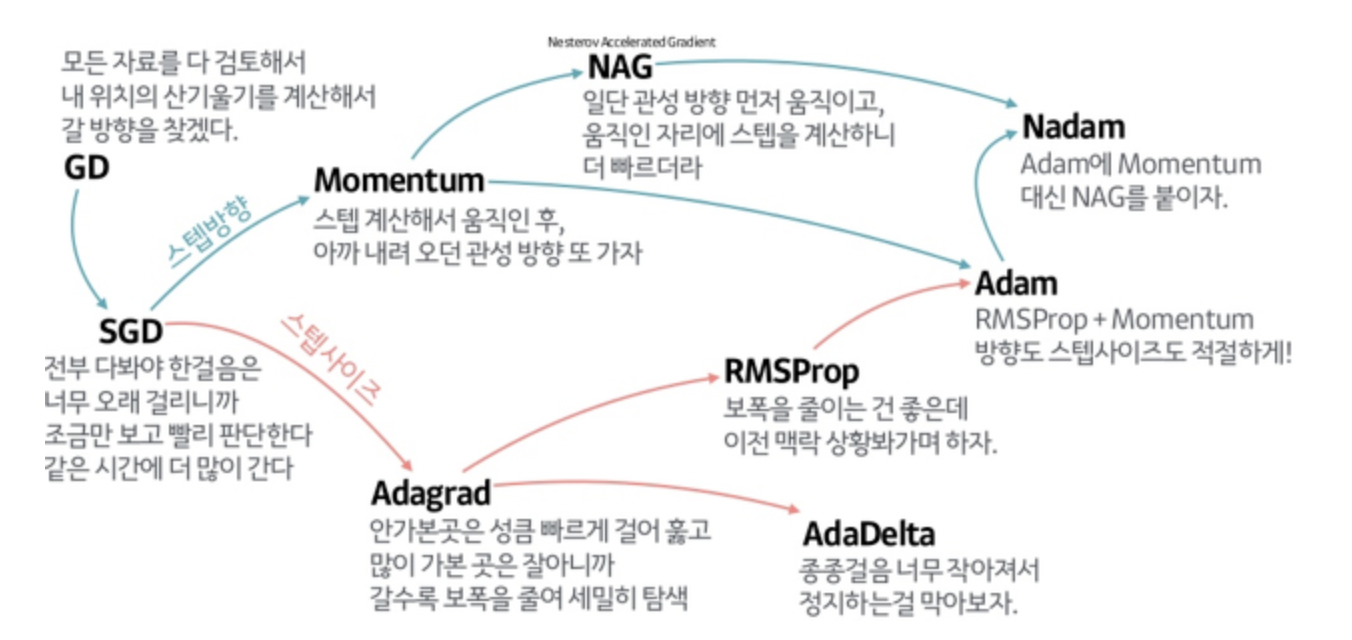

In [ ]:
# 옵티마이저 = AdamW (Adam + Weight Decay)
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
#losses = []
#accuracies = []

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

  0%|          | 0/4569 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


RuntimeError: ignored

In [ ]:
losses, accuracies

([1787.7003167495131,
  1391.6650311686099,
  1254.219527117908,
  1160.9980290792882,
  1076.0059413462877],
 [tensor(0.8249, device='cuda:0'),
  tensor(0.8704, device='cuda:0'),
  tensor(0.8843, device='cuda:0'),
  tensor(0.8941, device='cuda:0'),
  tensor(0.9025, device='cuda:0')])

In [ ]:
# eval model

model.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)
print("Accuracy:", test_correct.float() / test_total)

  0%|          | 0/3073 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy: tensor(0.8869, device='cuda:0')


In [ ]:
import torch

In [ ]:
# Huggingface 이용하여 pre-trained 된 모델 불러오기

from transformers import ElectraModel,ElectraTokenizer,AutoTokenizer

model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator").to(device)
torch.save(model.state_dict(), "/content/drive/MyDrive/waynehills_sentimental_kor/model.pt")

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

def convert_input_data(sentences):
    tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    MAX_LEN = 128

    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# Test 
def test_sentences(sentences):

    model.eval()

    inputs, masks = convert_input_data(sentences)

    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
# 모델 출력 확인

sentence = ['오늘은 일찍 퇴근해서 그런가? 기분이 묘하네']
logits = test_sentences(sentence)
pred_postive = 100-np.max(logits)
pred_negative = 100+np.min(logits)

print(sentence)
print('모델이 예측한 레이블:', np.argmax(logits))
if np.argmax(logits) == 1:
  print("결과는 :{:.2f}% 확률로 긍정적 문장입니다.\n".format(pred_postive))
else:
  print("결과는 :{:.2f}% 확률로 부정적 문장입니다.\n".format(pred_negative))

['오늘은 일찍 퇴근해서 그런가? 기분이 묘하네']
모델이 예측한 레이블: 8388
결과는 :91.68% 확률로 부정적 문장입니다.



# Huggingface push

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,503 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!pip install huggingface-hub

In [ ]:
repo_name = 'waynehills_sentimental_kor'

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

ERROR:root:HfApi.login: This method is deprecated in favor of `set_access_token`.


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
model.push_to_hub(repo_name)
#tokenizer.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Doogie/waynehills_sentimental_kor into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.38k/54.0M [00:00<?, ?B/s]

To https://huggingface.co/Doogie/waynehills_sentimental_kor
   8d41522..453a353  main -> main

   8d41522..453a353  main -> main



NameError: ignored